In [1]:
import sys
!{sys.executable} -m pip install "numpy<2.0"



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install gradio



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np  # Importing NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting graphs and visualizations
import seaborn as sns  # Importing Seaborn for statistical data visualization, built on top of Matplotlib
import tensorflow as tf  # Importing TensorFlow for building and training machine learning models
from tensorflow import keras  # Importing Keras, a high-level API for TensorFlow, to simplify model building
from tensorflow.keras import Layer  # Importing Layer class for creating custom layers in Keras
from tensorflow.keras.models import Sequential  # Importing Sequential model for building neural networks layer-by-layer
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks  # Importing various modules for layers, optimizers, and callbacks in Keras
from sklearn.utils.class_weight import compute_class_weight  # Importing function to compute class weights for imbalanced datasets
from tensorflow.keras.applications import ResNet50V2  # Importing ResNet50V2 model for transfer learning (CHANGED FROM EfficientNetV2B2)
from sklearn.metrics import confusion_matrix, classification_report  # Importing functions to evaluate model performance
import gradio as gr  # Importing Gradio for creating interactive web interfaces for machine learning models

In [4]:
dataset_dir= r"C:\Users\harin\Downloads\archive (3)\TrashType_Image_Dataset"
image_size = (124, 124)
batch_size = 32
seed = 42

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size)
val_class= val_ds.class_names

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [7]:
# Get the total number of batches in the validation dataset
val_batches = tf.data.experimental.cardinality(val_ds)
# Split the validation dataset into two equal parts:
# First half becomes the test dataset
test_ds = val_ds.take(val_batches // 2)
# Second half remains as the validation dataset
val_dat = val_ds.skip(val_batches // 2)
# Optimize test dataset by caching and prefetching to improve performance
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [8]:
print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


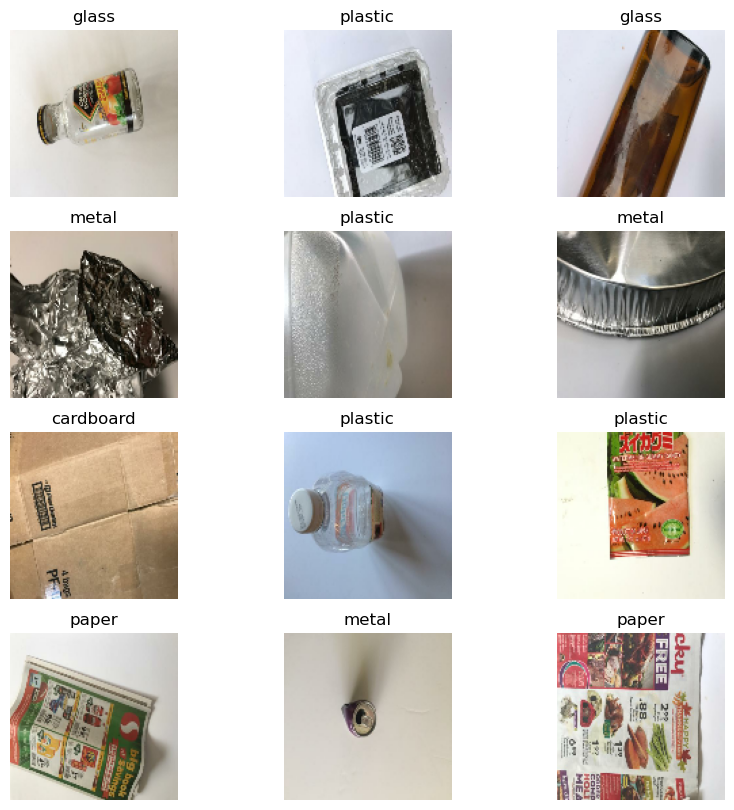

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [10]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}
    
    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to percentage
    return counts

In [11]:
# Function to plot class distribution
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

In [12]:
class_names = train_ds.class_names
# Get class distributions
train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)
overall_dist = {}
for k in class_names:
    overall_dist[k] = round((train_dist[k] + val_dist[k]) / 2, 2)
print(train_dist)
print(val_dist)
print(test_dist)
print(overall_dist)

{'cardboard': 16.52, 'glass': 19.73, 'metal': 15.92, 'paper': 23.29, 'plastic': 19.44, 'trash': 5.09}
{'cardboard': 13.66, 'glass': 20.2, 'metal': 17.43, 'paper': 24.36, 'plastic': 17.62, 'trash': 6.73}
{'cardboard': 14.06, 'glass': 17.58, 'metal': 16.8, 'paper': 25.0, 'plastic': 19.14, 'trash': 7.42}
{'cardboard': 15.09, 'glass': 19.96, 'metal': 16.68, 'paper': 23.82, 'plastic': 18.53, 'trash': 5.91}


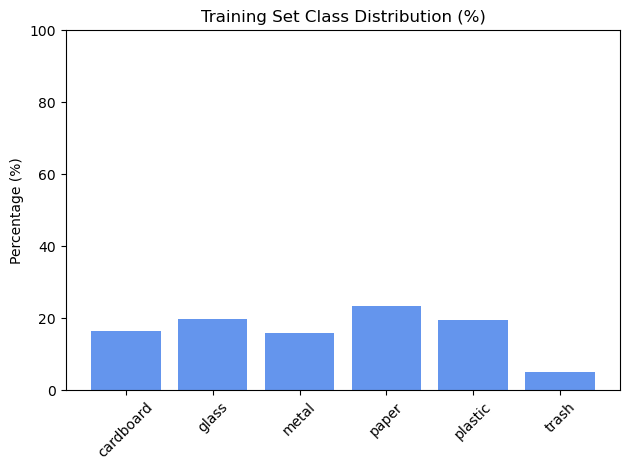

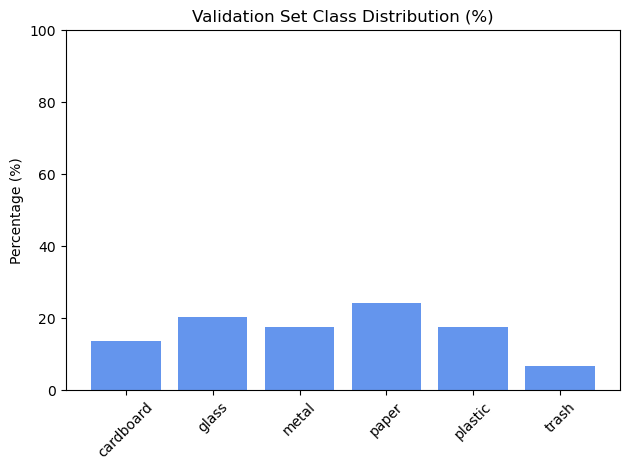

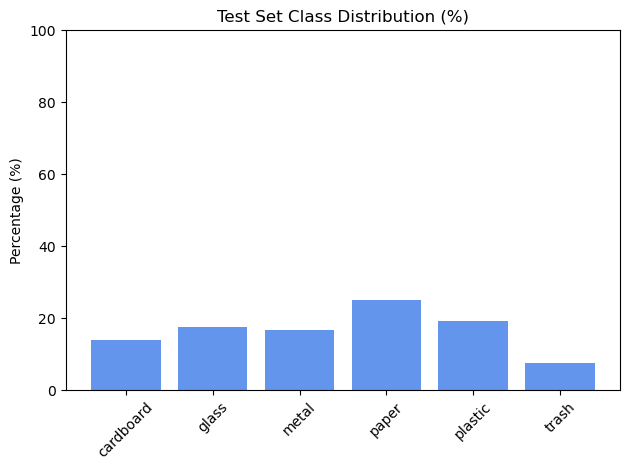

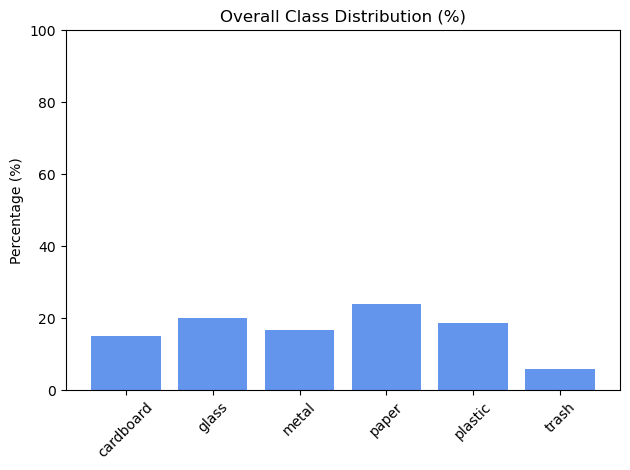

In [13]:
# Show visualizations
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")

In [14]:
# Count class occurrences and prepare label list
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []
for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1
        all_labels.append(label)

# Compute class weights (index aligned)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels)

# Create dictionary mapping class index to weight
class_weights = {i: w for i, w in enumerate(class_weights_array)}

In [15]:
# ✅ Optional: print results
print("Class Counts:", class_counts)
print("Class Weights:", class_weights)

Class Counts: {0: 334, 1: 399, 2: 322, 3: 471, 4: 393, 5: 103}
Class Weights: {0: 1.0089820359281436, 1: 0.8446115288220551, 2: 1.046583850931677, 3: 0.7154989384288747, 4: 0.8575063613231552, 5: 3.2718446601941746}


In [16]:
# Define data augmentation pipeline
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1), # Added RandomTranslation for more robust augmentation
    layers.RandomContrast(0.1),
])

In [17]:
# Load the pretrained ResNet50V2 model (without the top classification layer) (CHANGED FROM EfficientNetV2B2)
base_model = ResNet50V2(include_top=False, input_shape=(124, 124, 3), weights='imagenet')

# Freeze early layers (to retain general pretrained features)
base_model.trainable = True # Start with trainable=True for fine-tuning
for layer in base_model.layers[:100]:  # You can adjust this number
    layer.trainable = False

In [18]:
# Build the final model
model = Sequential([
    layers.Input(shape=(124, 124, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # Change to your number of classes
])

In [19]:
# ⚙️ Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])


In [20]:
# Define an EarlyStopping callback to stop training when validation loss stops improving
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor (validation loss here)
    patience=3,                   # Number of epochs to wait after last improvement before stopping
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)

# Define a ReduceLROnPlateau callback to reduce learning rate when a metric has stopped improving
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2, # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=5, # Number of epochs with no improvement after which learning rate will be reduced.
    min_lr=1e-7, # Lower bound on the learning rate.
    verbose=1 # Prints a message when the learning rate is updated
)

# Define a ModelCheckpoint callback to save the best model during training
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_resnet50v2_garbage_classifier.keras', # path to save the model file
    monitor='val_accuracy', # Metric to monitor for saving the best model
    save_best_only=True, # Only save when the monitored metric is better than previous best
    verbose=1 # Prints a message when saving a model
)

In [21]:
# Set the number of epochs to train the model
epochs_stage1 = 15  # Number of times the model will go through the entire dataset for initial training
epochs_stage2 = 10  # Additional epochs for fine-tuning

print("\n--- Stage 1: Initial Training with Frozen Base Model ---")
# Train the model using the fit function for Stage 1 (IMPROVEMENT: Two-stage fine-tuning)
history = model.fit(
    train_ds,
    validation_data=val_dat,
    epochs=epochs_stage1,
    class_weight=class_weights,
    batch_size=32,
    callbacks=[early, lr_scheduler, model_checkpoint]
)

print("\n--- Stage 2: Fine-tuning Unfrozen Layers of Base Model ---")
# Load the best model from Stage 1 to continue fine-tuning from the best point
model = tf.keras.models.load_model('best_resnet50v2_garbage_classifier.keras')

# Unfreeze more layers for fine-tuning (IMPROVEMENT: Better fine-tuning strategy)
# You can adjust this threshold to unfreeze more or fewer layers
for layer in base_model.layers[-50:]: # Unfreeze the last 50 layers of the base model
    if not isinstance(layer, layers.BatchNormalization): # Keep BatchNormalization layers frozen for stability
        layer.trainable = True

# Recompile the model with a much lower learning rate for fine-tuning
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5), # IMPROVEMENT: Very low learning rate for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_fine_tune = model.fit(
    train_ds,
    validation_data=val_dat,
    epochs=epochs_stage1 + epochs_stage2, # Total epochs will be sum of stage1 and stage2
    initial_epoch=history.epoch[-1], # Start from the epoch where initial training ended
    class_weight=class_weights,
    batch_size=32,
    callbacks=[early, lr_scheduler, model_checkpoint]
)

print("Model training (including fine-tuning) complete.")


--- Stage 1: Initial Training with Frozen Base Model ---
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3326 - loss: 1.6995
Epoch 1: val_accuracy improved from -inf to 0.22088, saving model to best_resnet50v2_garbage_classifier.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 297s 4s/step - accuracy: 0.3338 - loss: 1.6970 - val_accuracy: 0.2209 - val_loss: 5.3157 - learning_rate: 1.0000e-04
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5154 - loss: 1.2652
Epoch 2: val_accuracy improved from 0.22088 to 0.30522, saving model to best_resnet50v2_garbage_classifier.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 214s 3s/step - accuracy: 0.5158 - loss: 1.2642 - val_accuracy: 0.3052 - val_loss: 3.0758 - learning_rate: 1.0000e-04
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5791 - loss: 1.1476
Epoch 3: val_accuracy improved from 0.30522 to 0.49799, saving model to best_resnet50v2_garbage_classifier.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 282s 4s/step - accuracy: 0.5792 - loss: 1.

In [22]:
#Summary 
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 124, 124, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 4, 4, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │        12,294 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,721,428 (246.89 MB)

 Trainable params: 20,572,166 (78.48 MB)

 Non-trainable params: 3,004,928 (11.46 MB)

 Optimizer params: 41,144,334 (156.95 MB)

In [23]:
base_model.summary() # Print the architecture summary of the base model

Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 124, 124,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 130, 130,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 62, 62,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 64, 64,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 31, 31,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 31, 31,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 31, 31,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 31, 31,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 31, 31,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 31, 31,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 33, 33,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 31, 31,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 31, 31,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 31, 31,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 31, 31,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 31, 31,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 31, 31,    │          0 │ conv2_block1_0_c

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 20,559,872 (78.43 MB)

 Non-trainable params: 3,004,928 (11.46 MB)

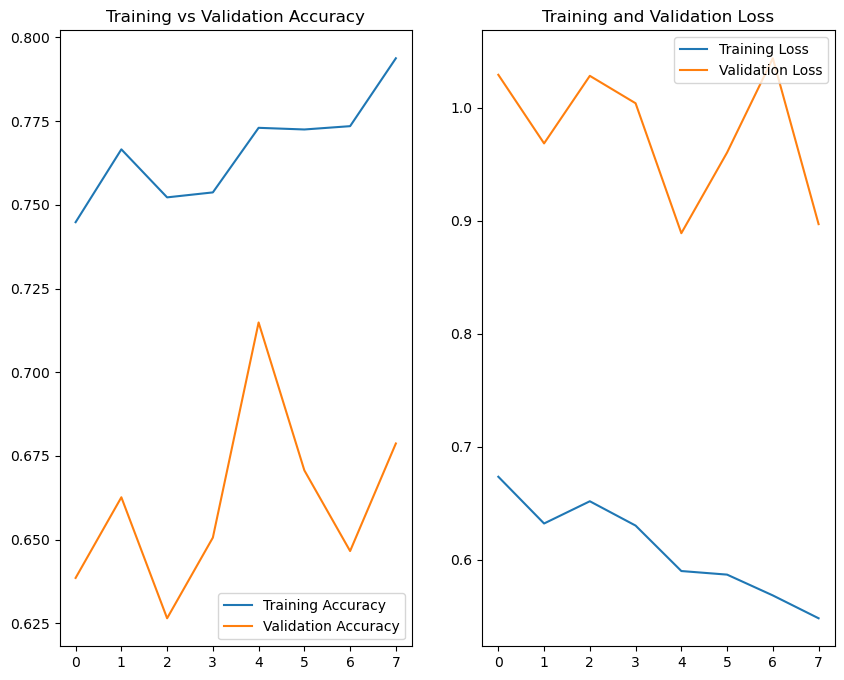

In [24]:
acc = history_fine_tune.history['accuracy']          # Extract training accuracy from fine-tuning history
val_acc = history_fine_tune.history['val_accuracy']  # Extract validation accuracy from fine-tuning history
loss = history_fine_tune.history['loss']             # Extract training loss from fine-tuning history
val_loss = history_fine_tune.history['val_loss']     # Extract validation loss from fine-tuning history
epochs_range = range(len(acc))             # Define range for epochs based on accuracy length

plt.figure(figsize=(10,8))                 # Set overall figure size for visualization
plt.subplot(1,2,1)                         # Create first subplot (1 row, 2 columns, position 1)
plt.plot(epochs_range, acc, label='Training Accuracy')       # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot validation accuracy
plt.legend(loc='lower right')              # Place legend in lower-right corner
plt.title('Training vs Validation Accuracy') # Add title for accuracy plot

plt.subplot(1,2,2)                         # Create second subplot (1 row, 2 columns, position 2)
plt.plot(epochs_range, loss, label='Training Loss')         # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')   # Plot validation loss
plt.legend(loc='upper right')              # Place legend in upper-right corner
plt.title('Training and Validation Loss')   # Add title for loss plot
plt.show()                                 # Display the plots


In [25]:
loss, accuracy = model.evaluate(test_ds_eval)
print(f'Test accuracy is {accuracy:.4f}, Test loss is {loss:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 868ms/step - accuracy: 0.7238 - loss: 0.8387
Test accuracy is 0.6992, Test loss is 0.9007
